# Beijing Air Quality Forecasting Starter Notebook

In [17]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import tensorflow as tf

In [39]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [19]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [43]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [44]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


In [45]:
train.head()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
datetime,,,,,,,,,,,
2010-01-01 00:00:00,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 01:00:00,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 02:00:00,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 03:00:00,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 04:00:00,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN


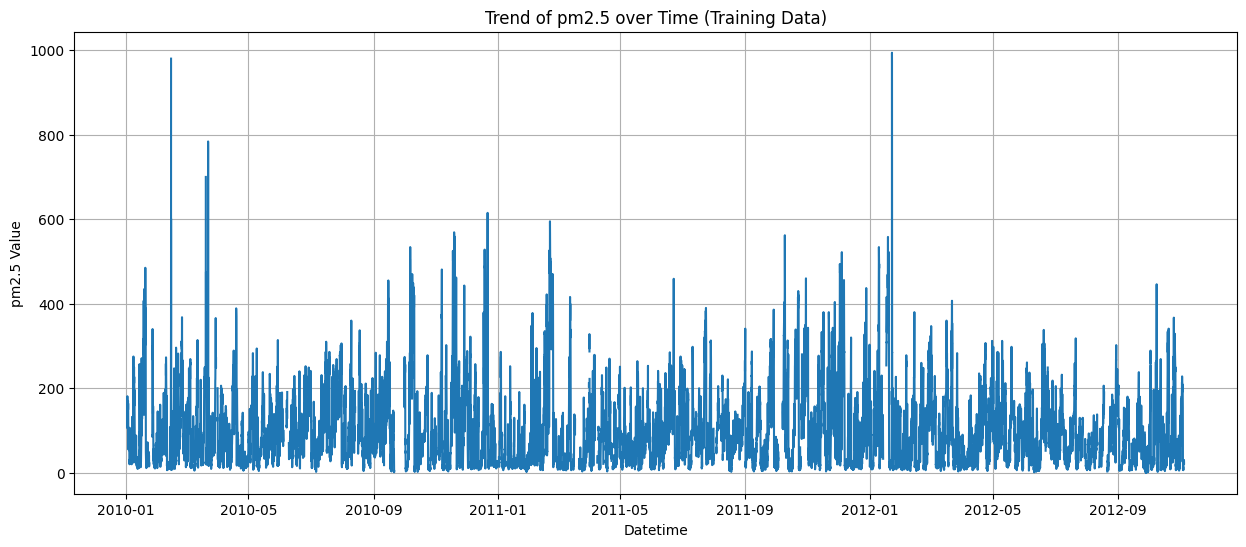

In [46]:
# Plotting for the trend of pm2.5 over time
plt.figure(figsize=(15, 6))
plt.plot(train.index, train['pm2.5'])
plt.title('Trend of pm2.5 over Time (Training Data)')
plt.xlabel('Datetime')
plt.ylabel('pm2.5 Value')
plt.grid(True)
plt.show()

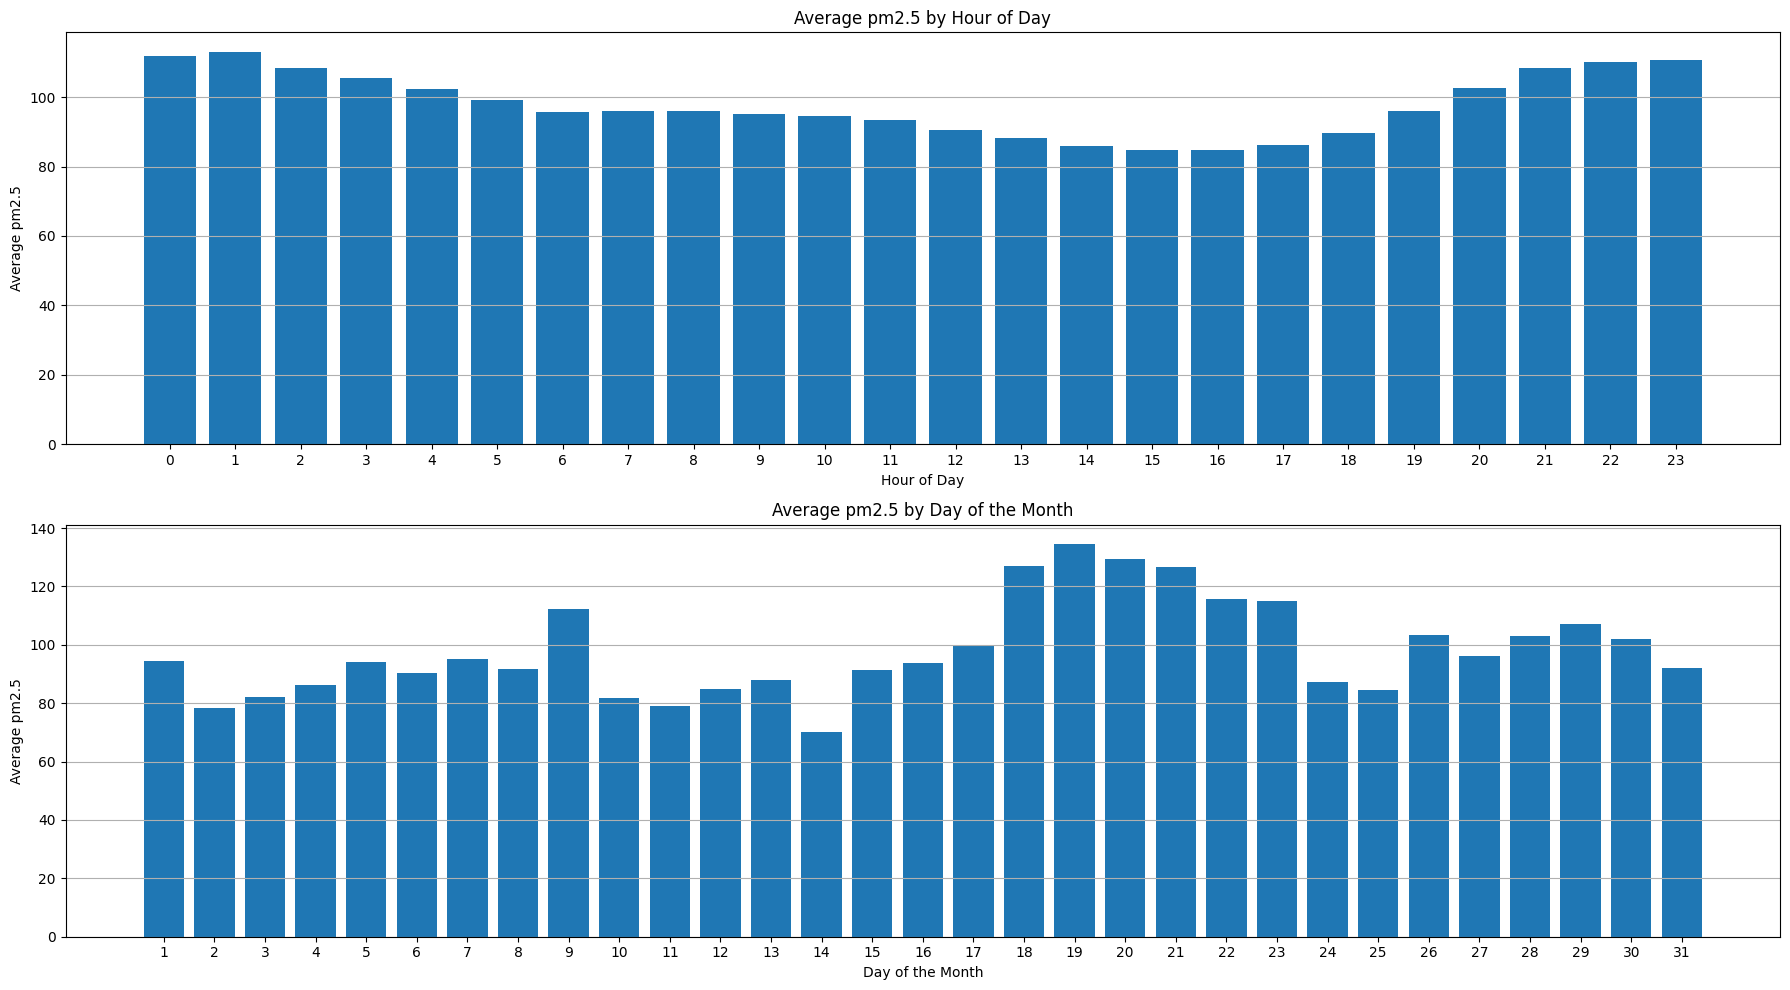

In [47]:
#Average pm2.5 by hour of the day and day of the months
hourly_pm25 = train.groupby(train.index.hour)['pm2.5'].mean()
daily_pm25 = train.groupby(train.index.day)['pm2.5'].mean()

fig, axes = plt.subplots(2, 1, figsize=(18, 10))

axes[0].bar(hourly_pm25.index, hourly_pm25.values)
axes[0].set_title('Average pm2.5 by Hour of Day')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Average pm2.5')
axes[0].set_xticks(hourly_pm25.index)
axes[0].grid(axis='y')

axes[1].bar(daily_pm25.index, daily_pm25.values)
axes[1].set_title('Average pm2.5 by Day of the Month')
axes[1].set_xlabel('Day of the Month')
axes[1].set_ylabel('Average pm2.5')
axes[1].set_xticks(daily_pm25.index)
axes[1].grid(axis='y')

plt.tight_layout()

plt.show()


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [48]:
# Checking for missing values
print("\nMissing Values:")
print(train.isnull().sum())
print("\n Test missing values:")
print(test.isnull().sum())


Missing Values:
No            0
DEWP          0
TEMP          0
PRES          0
Iws           0
Is            0
Ir            0
cbwd_NW       1
cbwd_SE       1
cbwd_cv       1
pm2.5      1735
dtype: int64

 Test missing values:
No         0
DEWP       0
TEMP       0
PRES       0
Iws        0
Is         0
Ir         0
cbwd_NW    0
cbwd_SE    0
cbwd_cv    0
dtype: int64


In [49]:
train.dropna(subset=['pm2.5'], inplace=True)

# Interpolate missing feature values using time
train.interpolate(method='time', inplace=True)
test.interpolate(method='time', inplace=True)

print(train.isnull().sum())


No         0
DEWP       0
TEMP       0
PRES       0
Iws        0
Is         0
Ir         0
cbwd_NW    0
cbwd_SE    0
cbwd_cv    0
pm2.5      0
dtype: int64


In [50]:
train.head()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
datetime,,,,,,,,,,,
2010-01-02 00:00:00,25,-1.234456,-1.348408,0.345943,-0.441894,-0.069353,-0.137667,-0.690542,1.366085,-0.522096,129.0
2010-01-02 01:00:00,26,-1.165172,-1.348408,0.345943,-0.424097,-0.069353,-0.137667,-0.690542,1.366085,-0.522096,148.0
2010-01-02 02:00:00,27,-0.888034,-1.430386,0.443328,-0.406301,-0.069353,-0.137667,-0.690542,1.366085,-0.522096,159.0
2010-01-02 03:00:00,28,-0.610897,-1.430386,0.540712,-0.370508,1.245803,-0.137667,-0.690542,1.366085,-0.522096,181.0
2010-01-02 04:00:00,29,-0.610897,-1.430386,0.540712,-0.352712,2.560959,-0.137667,-0.690542,1.366085,-0.522096,138.0


# **Feature Engineering**

In [94]:
train['datetime'] = train.index
test['datetime'] = test.index

# Extract time features
for df in [train, test]:
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
#Drop again the datetime column
train.drop(columns=['datetime'], inplace=True)
test.drop(columns=['datetime'], inplace=True)


train.head()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5,hour,dayofweek,month
datetime,,,,,,,,,,,,,,
2010-01-02 00:00:00,25,-1.234456,-1.348408,0.345943,-0.441894,-0.069353,-0.137667,-0.690542,1.366085,-0.522096,129.0,0,5,1
2010-01-02 01:00:00,26,-1.165172,-1.348408,0.345943,-0.424097,-0.069353,-0.137667,-0.690542,1.366085,-0.522096,148.0,1,5,1
2010-01-02 02:00:00,27,-0.888034,-1.430386,0.443328,-0.406301,-0.069353,-0.137667,-0.690542,1.366085,-0.522096,159.0,2,5,1
2010-01-02 03:00:00,28,-0.610897,-1.430386,0.540712,-0.370508,1.245803,-0.137667,-0.690542,1.366085,-0.522096,181.0,3,5,1
2010-01-02 04:00:00,29,-0.610897,-1.430386,0.540712,-0.352712,2.560959,-0.137667,-0.690542,1.366085,-0.522096,138.0,4,5,1


In [98]:
train_high_pm25 = train[train['pm2.5'] >= 290]
print(train_high_pm25)

                        No      DEWP      TEMP      PRES       Iws        Is  \
datetime                                                                       
2010-01-17 21:00:00    406 -0.818750 -1.594341  1.027634 -0.459690 -0.069353   
2010-01-17 22:00:00    407 -0.888034 -1.758296  1.027634 -0.450692 -0.069353   
2010-01-17 23:00:00    408 -0.957319 -1.758296  1.027634 -0.459890 -0.069353   
2010-01-18 02:00:00    411 -0.888034 -1.758296  1.125019 -0.379306 -0.069353   
2010-01-18 03:00:00    412 -1.026603 -1.840273  1.125019 -0.343514 -0.069353   
...                    ...       ...       ...       ...       ...       ...   
2012-10-26 21:00:00  24718  0.705505  0.127186  0.053790 -0.325717 -0.069353   
2012-10-26 22:00:00  24719  0.705505  0.209164  0.053790 -0.289924 -0.069353   
2012-10-26 23:00:00  24720  0.705505  0.127186  0.053790 -0.227337 -0.069353   
2012-10-27 00:00:00  24721  0.705505  0.127186 -0.043595 -0.164750 -0.069353   
2012-10-27 01:00:00  24722  0.636221  0.

In [52]:
train.shape

(23201, 14)

Correlation with pm2.5:
pm2.5        1.000000
DEWP         0.241785
cbwd_cv      0.161376
cbwd_SE      0.124321
month        0.078075
TEMP         0.005622
Is          -0.005445
dayofweek   -0.007310
hour        -0.024284
No          -0.035611
Ir          -0.056447
PRES        -0.141667
cbwd_NW     -0.241323
Iws         -0.257431
Name: pm2.5, dtype: float64


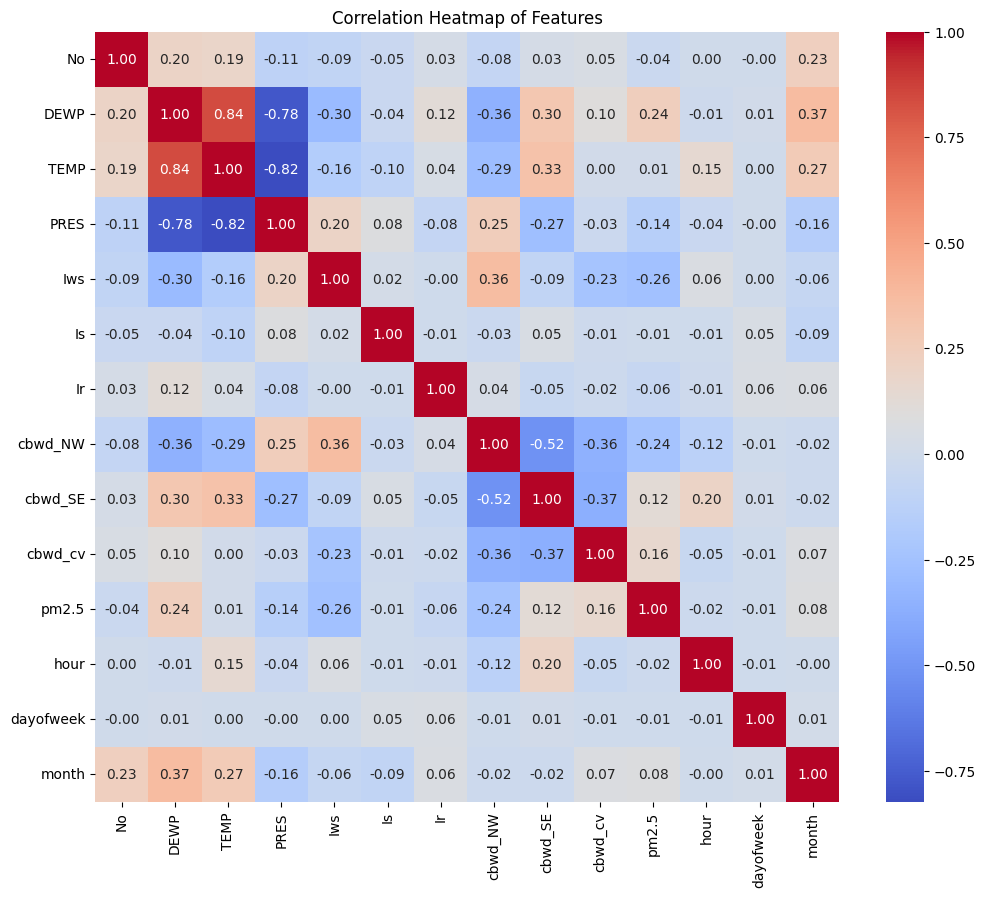

In [53]:
# Calculate the correlation matrix
correlation_matrix = train.corr()

# Get the correlations of all features with the target variable ('pm2.5')
target_correlations = correlation_matrix['pm2.5'].sort_values(ascending=False)

print("Correlation with pm2.5:")
print(target_correlations)

import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [54]:
from sklearn.preprocessing import StandardScaler

# Drop target column temporarily to get features
features = train.drop(columns=['pm2.5', 'No'])
target = train['pm2.5'].values

# Initialize scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Fit-transform features and target
scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1)).flatten()


In [55]:
# Creating sequence function
def create_sequences(data, target, window_size):
    assert len(data) == len(target)
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)

In [56]:
# Build sequences with window size
window_size = 36
X_train_seq, y_train_seq = create_sequences(scaled_features, scaled_target, window_size)

In [57]:
print(X_train_seq.shape, y_train_seq.shape)

(23165, 36, 12) (23165,)


In [58]:
# Splitting  the for validation and training
split_index = int(len(X_train_seq) * 0.8)
X_train_seq, X_val = X_train_seq[:split_index], X_train_seq[split_index:]
y_train_seq, y_val = y_train_seq[:split_index], y_train_seq[split_index:]


# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [67]:
# define model
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(32, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True, dropout=0.2),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(16, activation='tanh', return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)
])

# Define RMSE metric function
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

optimizer = Adam(learning_rate=0.0005)

# Compile the model using MAE as the loss function and RMSE as a metric
model.compile(
    optimizer=optimizer,
    loss='mae',
    metrics=[rmse]
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce rate for val_loss plateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Display the model architecture
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 36, 32)         │         5,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 36, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 36, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,105 (35.57 KB)

 Trainable params: 9,009 (35.19 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - loss: 0.8960 - rmse: 1.3998 - val_loss: 0.5606 - val_rmse: 0.7386 - learning_rate: 0.0010
Epoch 2/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 39s 36ms/step - loss: 0.6230 - rmse: 1.2469 - val_loss: 0.5139 - val_rmse: 0.6853 - learning_rate: 0.0010
Epoch 3/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - loss: 0.5581 - rmse: 1.1923 - val_loss: 0.5873 - val_rmse: 0.7641 - learning_rate: 0.0010
Epoch 4/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 0.5356 - rmse: 1.1968 - val_loss: 0.5405 - val_rmse: 0.7284 - learning_rate: 0.0010
Epoch 5/20
579/580 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5193 - rmse: 1.2039
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
580/580 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - loss: 0.5193 - rmse: 1.2040 - val_loss: 0.5327 - val_rmse: 0.7233 - learning_rate: 0.0010
Epoch 6/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - loss: 0.5106 - rmse: 1.2251 - val_loss: 0.4966 - val_rmse: 0.6851 

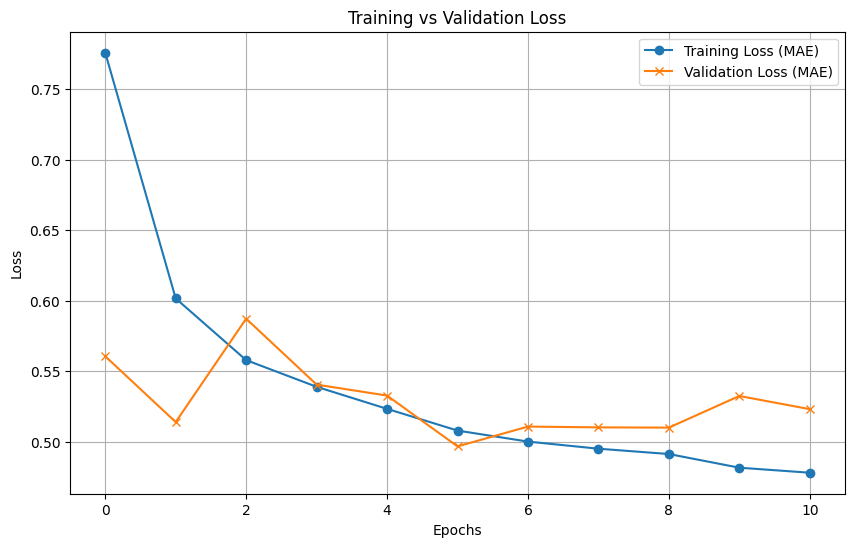

In [68]:
# Train the model
# You can adjust the number of epochs and batch size to improve performance.
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler]
)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss (MAE)', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss (MAE)', marker='x')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

580/580 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step


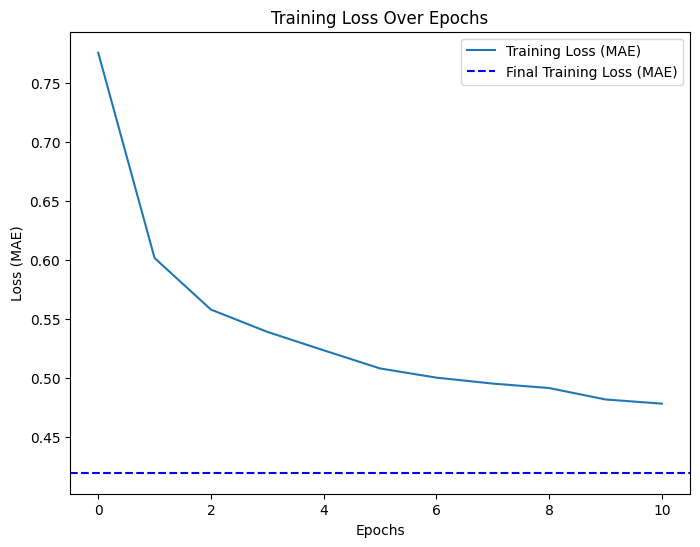

Final Training Loss (MAE): 0.4193


In [69]:
# Calculate final training loss (MAE to match model's loss function)
train_predictions = model.predict(X_train_seq)
train_loss = np.mean(np.abs(y_train_seq - train_predictions.flatten()))

# Plot training loss during epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss (MAE)')
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final Training Loss (MAE)')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MAE): {train_loss:.4f}")


In [100]:
# Prepare the test data
# Use same scaler used on train
test_features = test.drop(columns=['No'])
test_scaled = feature_scaler.transform(test_features)

# Combine last 24 points from training to the beginning of test
last_24_train = scaled_features[-window_size:]
combined = np.vstack([last_24_train, test_scaled])

# Create sliding windows for test data
X_test_seq = []
for i in range(len(test_scaled)):
    X_test_seq.append(combined[i:i+window_size])
X_test_seq = np.array(X_test_seq)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test_seq)

# Appling inverse transform using target scaler
predictions = target_scaler.inverse_transform(predictions)

#Ensuring no negative values
predictions = np.clip(predictions, 0, None)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/subm_fixed.csv', index=False)
print(X_test_seq.shape)

411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
(13148, 36, 12)


In [84]:
# Basic statistics
print("Prediction summary:")
print(f"Min: {predictions.min()}")
print(f"Max: {predictions.max()}")
print(f"Mean: {predictions.mean():.2f}")
print(f"Std: {predictions.std():.2f}")


Prediction summary:
Min: 66
Max: 135
Mean: 99.07
Std: 7.07


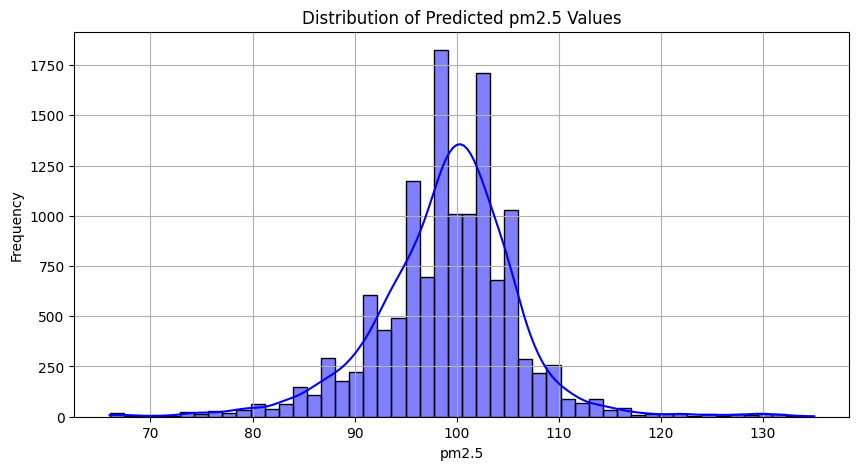

In [85]:
#Distribution of predicted pm2.5 values
plt.figure(figsize=(10, 5))
sns.histplot(predictions.flatten(), bins=50, kde=True, color='blue')
plt.title("Distribution of Predicted pm2.5 Values")
plt.xlabel("pm2.5")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


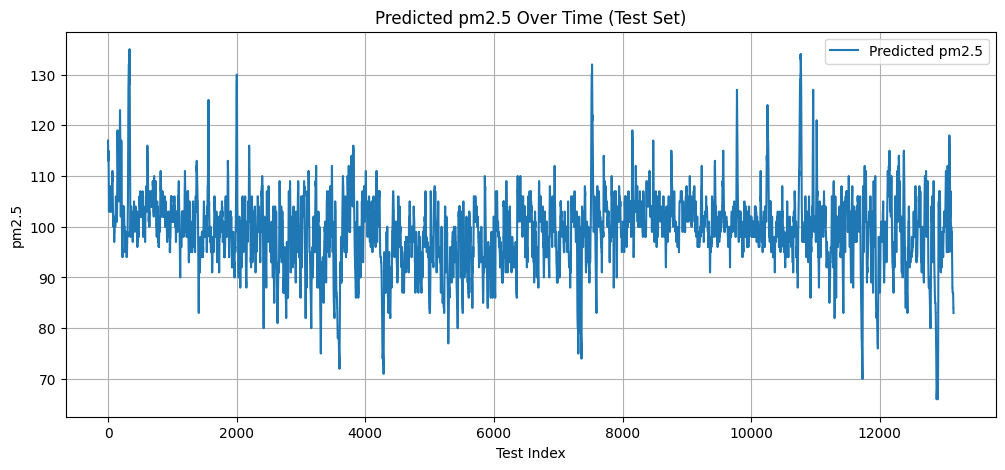

In [86]:
#Predicted pm2.5 over time
plt.figure(figsize=(12, 5))
plt.plot(predictions.flatten(), label='Predicted pm2.5')
plt.title("Predicted pm2.5 Over Time (Test Set)")
plt.xlabel("Test Index")
plt.ylabel("pm2.5")
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-87-5634f3d433a8>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(target, label="Train Targets", shade=True)
<ipython-input-87-5634f3d433a8>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(predictions.flatten(), label="Test Predictions", shade=True)


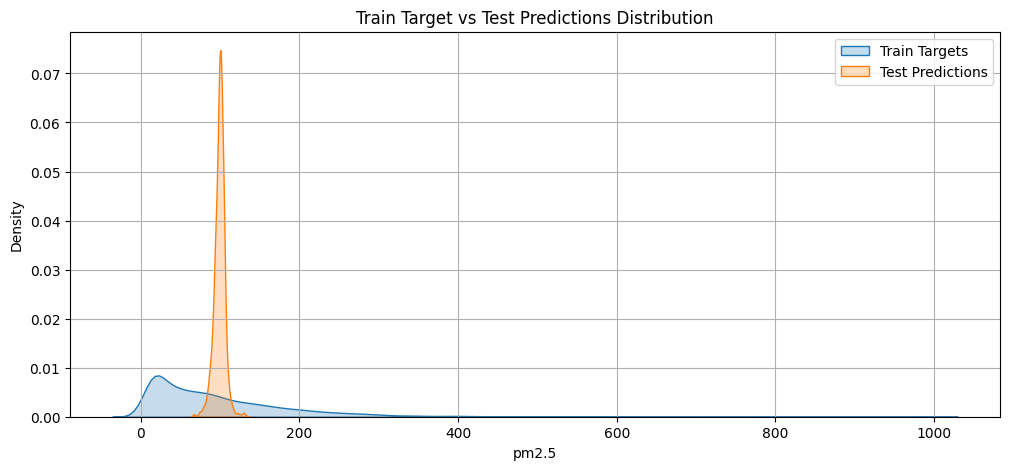

In [87]:
#Distribution of train and test targets
plt.figure(figsize=(12, 5))
sns.kdeplot(target, label="Train Targets", shade=True)
sns.kdeplot(predictions.flatten(), label="Test Predictions", shade=True)
plt.title("Train Target vs Test Predictions Distribution")
plt.xlabel("pm2.5")
plt.legend()
plt.grid(True)
plt.show()


# **Another One**

In [73]:
# define model
model_2 = Sequential([
    LSTM(32, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True, dropout=0.2),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(16, activation='tanh', return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)
])

# Define RMSE metric function
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

optimizer = Adam(learning_rate=0.0005)

# Compile the model using MAE as the loss function and RMSE as a metric
model_2.compile(
    optimizer=optimizer,
    loss='mae',
    metrics=[rmse]
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Reduce rate for val_loss plateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Display the model architecture
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 36, 32)         │         5,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 36, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 36, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,105 (35.57 KB)

 Trainable params: 9,009 (35.19 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - loss: 0.9403 - rmse: 1.4221 - val_loss: 0.5712 - val_rmse: 0.7063 - learning_rate: 5.0000e-04
Epoch 2/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - loss: 0.6967 - rmse: 1.2512 - val_loss: 0.5515 - val_rmse: 0.7033 - learning_rate: 5.0000e-04
Epoch 3/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - loss: 0.6182 - rmse: 1.2181 - val_loss: 0.5650 - val_rmse: 0.7250 - learning_rate: 5.0000e-04
Epoch 4/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - loss: 0.5891 - rmse: 1.2193 - val_loss: 0.5422 - val_rmse: 0.7047 - learning_rate: 5.0000e-04
Epoch 5/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - loss: 0.5495 - rmse: 1.2038 - val_loss: 0.5331 - val_rmse: 0.6939 - learning_rate: 5.0000e-04
Epoch 6/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - loss: 0.5487 - rmse: 1.2293 - val_loss: 0.5339 - val_rmse: 0.7069 - learning_rate: 5.0000e-04
Epoch 7/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - loss: 0.5234 - rmse: 1.2152 - val_loss: 0.53

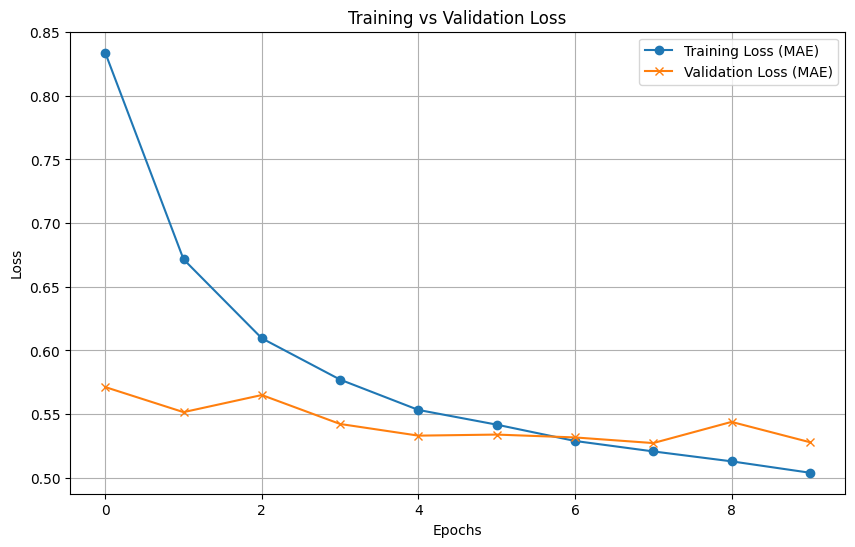

In [74]:
# You can adjust the number of epochs and batch size to improve performance.
history_2 = model_2.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler]
)

plt.figure(figsize=(10, 6))
plt.plot(history_2.history['loss'], label='Training Loss (MAE)', marker='o')
plt.plot(history_2.history['val_loss'], label='Validation Loss (MAE)', marker='x')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

580/580 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step


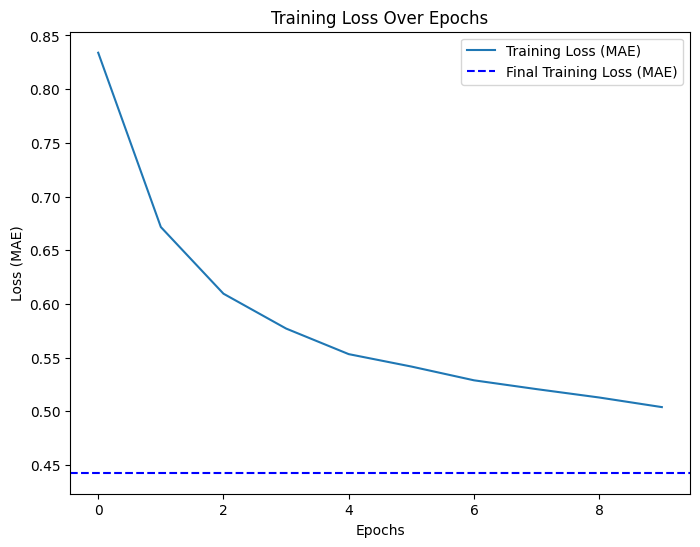

Final Training Loss (MAE): 0.4428


In [75]:
# Calculate final training loss (MAE to match model's loss function)
train_predictions = model_2.predict(X_train_seq)
train_loss = np.mean(np.abs(y_train_seq - train_predictions.flatten()))

# Plot training loss during epochs
plt.figure(figsize=(8, 6))
plt.plot(history_2.history['loss'], label='Training Loss (MAE)')
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final Training Loss (MAE)')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MAE): {train_loss:.4f}")

In [99]:
# Prepare the test data
# Use same scaler used on train
test_features = test.drop(columns=['No'])
test_scaled = feature_scaler.transform(test_features)

# Combine last 24 points from training to the beginning of test
last_24_train = scaled_features[-window_size:]
combined = np.vstack([last_24_train, test_scaled])

# Create sliding windows for test data
X_test_seq = []
for i in range(len(test_scaled)):
    X_test_seq.append(combined[i:i+window_size])
X_test_seq = np.array(X_test_seq)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model_2.predict(X_test_seq)

# Appling inverse transform using target scaler
predictions = target_scaler.inverse_transform(predictions)

#Ensuring no negative values
predictions = np.clip(predictions, 0, None)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/subm_fixed1.csv', index=False)
print(X_test_seq.shape)

411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
(13148, 36, 12)


In [89]:
# Basic statistics
print("Prediction summary:")
print(f"Min: {predictions.min()}")
print(f"Max: {predictions.max()}")
print(f"Mean: {predictions.mean():.2f}")
print(f"Std: {predictions.std():.2f}")


Prediction summary:
Min: 9
Max: 299
Mean: 99.99
Std: 64.37


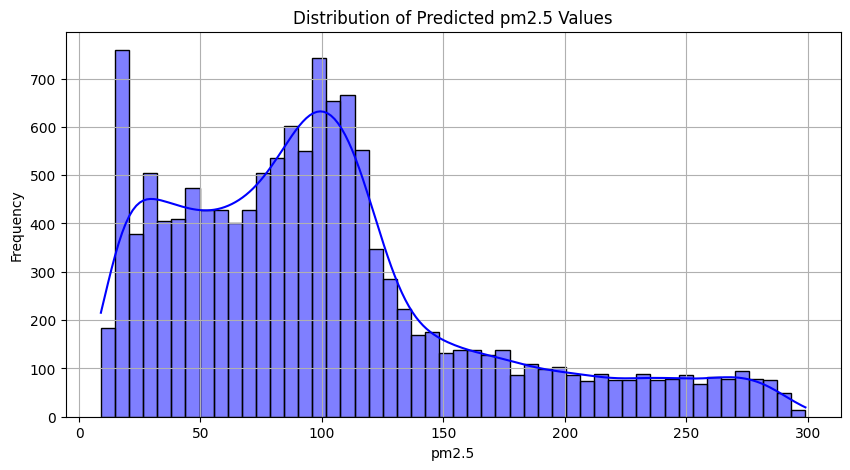

In [90]:
#Distribution of predicted pm2.5 values
plt.figure(figsize=(10, 5))
sns.histplot(predictions.flatten(), bins=50, kde=True, color='blue')
plt.title("Distribution of Predicted pm2.5 Values")
plt.xlabel("pm2.5")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


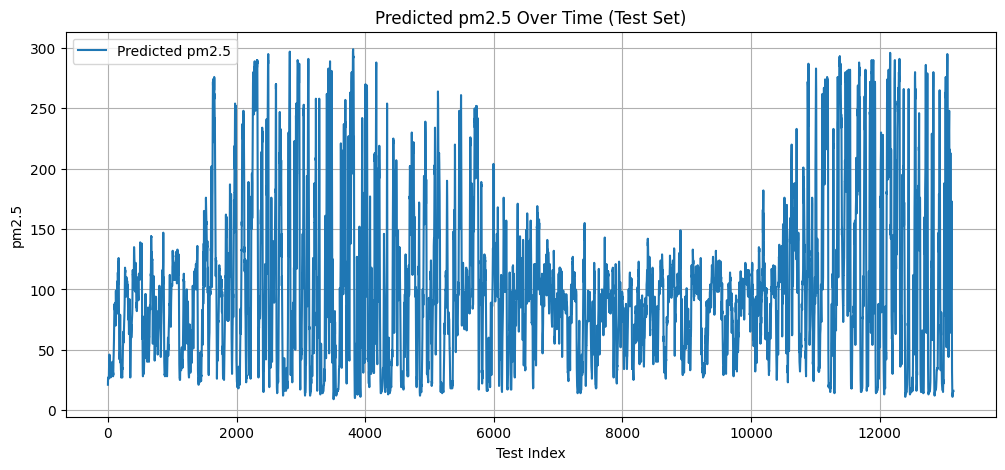

In [91]:
#Predicted pm2.5 over time
plt.figure(figsize=(12, 5))
plt.plot(predictions.flatten(), label='Predicted pm2.5')
plt.title("Predicted pm2.5 Over Time (Test Set)")
plt.xlabel("Test Index")
plt.ylabel("pm2.5")
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-92-5634f3d433a8>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(target, label="Train Targets", shade=True)
<ipython-input-92-5634f3d433a8>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(predictions.flatten(), label="Test Predictions", shade=True)


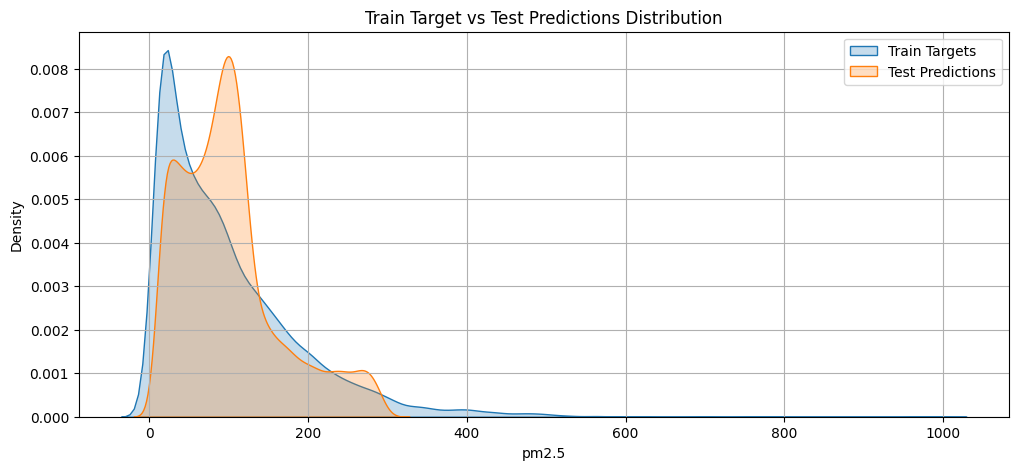

In [92]:
#Distribution of train and test targets
plt.figure(figsize=(12, 5))
sns.kdeplot(target, label="Train Targets", shade=True)
sns.kdeplot(predictions.flatten(), label="Test Predictions", shade=True)
plt.title("Train Target vs Test Predictions Distribution")
plt.xlabel("pm2.5")
plt.legend()
plt.grid(True)
plt.show()
